Texas Energy Demand Forecasting
-------------------------------------------------------------------------


# 1. Introduction

On January 1, 2002, the Texas State Legislature decided to deregulate the electricity industry and open up the supply of electricity to competition. [1] The Electric Reliability Council of Texas (ERCOT), which was formed in 1970, is the organization responsible for managing the flow of electricity to the majority of customers living in Texas via an electric grid and helping to manage regulations for Texas utilities. [1] As the independent system operator for the region, ERCOT schedules power on an electric grid that connects more than 46,500 miles of transmission lines and 710+ generation units to supply more than 26 million Texas customers – representing about 90% of the state’s electric load. [2]

In 2021, the State of Texas suffered a major power crisis which came about as a result of three severe winter storms sweeping across the United States on February 10-11, 13-17, and 15-20. [3] The Texas power outage, which has left millions without power, happened due to the increased use of heaters ramped up power use under the extreme weather, and the wells and pipes of the primary energy source, gas, got frozen and blocked. [4]

Nowadays, there is an irresistible trend of the electric power improvement for developing the smart grids, which applies a large number of new technologies in power generation, transmission, distribution and utilization to achieve optimization of the power configuration and energy saving. [5] Electricity load forecasting in smart grid is crucial to prevent similar power crises across the States and to help ERCOT to predict electricity usage under extreme weather in Winter. Short-term electric load forecasting forecasts the load that is several hours to several weeks ahead. [6] However, accurate forecasting is challenging due to the nonlinear, non-stationary, and nonseasonal nature of the electric load time series. [6]

The purpose of this project is to exploit the long-term dependencies in the electric load time series in the States of Texas for predicting more accurate electricity usage by using the recurrent neural network and to help ERCOT develop a contingency plan to respond to the high demand electricity usage under extreme weather.


# Reading the demand and weather data


In [ ]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

# Demand Data

Read the demand data.

In [ ]:
# https://drive.google.com/file/d/1M7-XiHcfboUzKZ-tmflDomy_IuRAvnw9/view?usp=sharing
!gdown --id 1M7-XiHcfboUzKZ-tmflDomy_IuRAvnw9

Downloading...
From: https://drive.google.com/uc?id=1M7-XiHcfboUzKZ-tmflDomy_IuRAvnw9
To: /content/Ercot_2011_2021_feb.csv
3.52MB [00:00, 55.4MB/s]


In [ ]:
energy = pd.read_csv('Ercot_2011_2021_feb.csv') # it just downloaded locally to your workspace!
energy.head()

,Unnamed: 0,Date,HE,MWh
0,0,2010-01-01,1,32094.064435
1,1,2010-01-01,2,32171.322546
2,2,2010-01-01,3,32241.752463
3,3,2010-01-01,4,32459.193227
4,4,2010-01-01,5,33123.751047


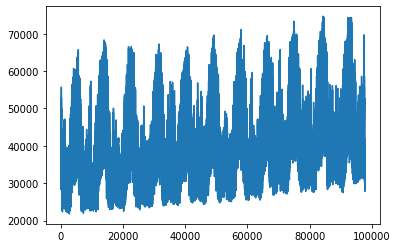

In [ ]:
# this is your target variable
energy['MWh'].plot()
plt.show()

Pretty cool - looks like energy variabes between 20K and 70K megawatts.

In [ ]:
print(energy['Date'].min())
print(energy['Date'].max())

2010-01-01
2021-03-01


In [ ]:
energy.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 97848 entries, 0 to 97847
Data columns (total 4 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   Unnamed: 0  97848 non-null  int64  
 1   Date        97848 non-null  object 
 2   HE          97848 non-null  int64  
 3   MWh         97847 non-null  float64
dtypes: float64(1), int64(2), object(1)
memory usage: 3.0+ MB


In [ ]:
#dropping unnamed column 
del energy['Unnamed: 0']
energy.head()

,Date,HE,MWh
0,2010-01-01,1,32094.064435
1,2010-01-01,2,32171.322546
2,2010-01-01,3,32241.752463
3,2010-01-01,4,32459.193227
4,2010-01-01,5,33123.751047


In [ ]:
#converting the datatype of date column from object to date
energy['Date'] = pd.to_datetime(energy.Date) + energy.HE.astype('timedelta64[h]')
energy.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 97848 entries, 0 to 97847
Data columns (total 3 columns):
 #   Column  Non-Null Count  Dtype         
---  ------  --------------  -----         
 0   Date    97848 non-null  datetime64[ns]
 1   HE      97848 non-null  int64         
 2   MWh     97847 non-null  float64       
dtypes: datetime64[ns](1), float64(1), int64(1)
memory usage: 2.2 MB


In [ ]:
energy.head()

,Date,HE,MWh
0,2010-01-01 01:00:00,1,32094.064435
1,2010-01-01 02:00:00,2,32171.322546
2,2010-01-01 03:00:00,3,32241.752463
3,2010-01-01 04:00:00,4,32459.193227
4,2010-01-01 05:00:00,5,33123.751047


In [ ]:
# Now that we have timestamps with dates, we don't need HE column
del energy['HE']
energy.head()

,Date,MWh
0,2010-01-01 01:00:00,32094.064435
1,2010-01-01 02:00:00,32171.322546
2,2010-01-01 03:00:00,32241.752463
3,2010-01-01 04:00:00,32459.193227
4,2010-01-01 05:00:00,33123.751047


#Sampling the data 

In [ ]:
#sampling the data to get the records between 2011 to 2014
energy_sampled = energy[energy.Date.between('2011-01-01', '2014-12-31')]
energy_sampled.head()

,Date,MWh
8759,2011-01-01 00:00:00,28496.388850
8760,2011-01-01 01:00:00,27662.443480
8761,2011-01-01 02:00:00,27250.044715
8762,2011-01-01 03:00:00,26783.226081
8763,2011-01-01 04:00:00,26676.468490


In [ ]:
energy_sampled.tail()

,Date,MWh
43795,2014-12-30 20:00:00,44649.492836
43796,2014-12-30 21:00:00,44206.514608
43797,2014-12-30 22:00:00,43176.997456
43798,2014-12-30 23:00:00,41461.699725
43799,2014-12-31 00:00:00,39573.518340


#Exploring missing values for each column

In [ ]:
energy_sampled.isnull().sum()

Date    0
MWh     0
dtype: int64

There are no missing values in the sampled dataset

# Weather Data

Read the weather data.

In [ ]:
# https://drive.google.com/file/d/1vl2RKquLYS1QRyYE7ySIj24jPnXFp2od/view?usp=sharing
!gdown --id 1vl2RKquLYS1QRyYE7ySIj24jPnXFp2od

Downloading...
From: https://drive.google.com/uc?id=1vl2RKquLYS1QRyYE7ySIj24jPnXFp2od
To: /content/FST.csv
97.2MB [00:00, 119MB/s]


In [ ]:
weather = pd.read_csv('FST.csv')
weather.head()

/usr/local/lib/python3.7/dist-packages/IPython/core/interactiveshell.py:2718: DtypeWarning: Columns (8) have mixed types.Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


,station,valid,tmpf,dwpf,relh,drct,sknt,p01i,alti,mslp,vsby,gust,skyc1,skyc2,skyc3,skyc4,skyl1,skyl2,skyl3,skyl4,wxcodes,ice_accretion_1hr,ice_accretion_3hr,ice_accretion_6hr,peak_wind_gust,peak_wind_drct,peak_wind_time,feel,metar
0,FST,2010-01-01 00:53,30.02,24.98,81.27,180.00,5.00,M,30.50,1031.80,10.00,M,CLR,,,M,M,M,M,M,M,M,M,M,M,M,M,24.04,METAR KFST 010553Z AUTO 18005KT 10SM CLR M01/M...
1,FST,2010-01-01 01:53,28.04,24.08,84.87,190.00,5.00,M,30.49,1031.30,10.00,M,CLR,,,M,M,M,M,M,M,M,M,M,M,M,M,21.69,METAR KFST 010653Z AUTO 19005KT 10SM CLR M02/M...
2,FST,2010-01-01 02:53,26.96,23.00,84.80,220.00,9.00,M,30.47,1030.90,10.00,M,CLR,,,M,M,M,M,M,M,M,M,M,M,M,M,17.25,METAR KFST 010753Z AUTO 22009KT 10SM CLR M03/M...
3,FST,2010-01-01 03:53,26.96,23.00,84.80,210.00,8.00,M,30.46,1030.40,10.00,M,CLR,,,M,M,M,M,M,M,M,M,M,M,M,M,17.90,METAR KFST 010853Z AUTO 21008KT 10SM CLR M03/M...
4,FST,2010-01-01 04:53,28.04,23.00,81.11,220.00,12.00,M,30.44,1030.00,10.00,M,CLR,,,M,M,M,M,M,M,M,M,M,M,M,M,16.96,METAR KFST 010953Z AUTO 22012KT 10SM CLR M02/M...


In [ ]:
# convert time stamp to datetime for interpolation
weather['valid'] = pd.to_datetime(weather['valid'])
weather.dtypes

station                      object
valid                datetime64[ns]
tmpf                         object
dwpf                         object
relh                         object
drct                         object
sknt                         object
p01i                         object
alti                         object
mslp                         object
vsby                         object
gust                         object
skyc1                        object
skyc2                        object
skyc3                        object
skyc4                        object
skyl1                        object
skyl2                        object
skyl3                        object
skyl4                        object
wxcodes                      object
ice_accretion_1hr            object
ice_accretion_3hr            object
ice_accretion_6hr            object
peak_wind_gust               object
peak_wind_drct               object
peak_wind_time               object
feel                        

In [ ]:
# look at the datetime range
print(weather['valid'].min())
print(weather['valid'].max())

2010-01-01 00:53:00
2021-02-19 23:55:00


In [ ]:
# set the datetime as the index so you can do interpolation later
weather.set_index(weather['valid'], inplace=True)
weather.head() # see how the valid column is now the index? this will allow
                # you to do resampling to hourly resolution

,station,valid,tmpf,dwpf,relh,drct,sknt,p01i,alti,mslp,vsby,gust,skyc1,skyc2,skyc3,skyc4,skyl1,skyl2,skyl3,skyl4,wxcodes,ice_accretion_1hr,ice_accretion_3hr,ice_accretion_6hr,peak_wind_gust,peak_wind_drct,peak_wind_time,feel,metar
valid,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2010-01-01 00:53:00,FST,2010-01-01 00:53:00,30.02,24.98,81.27,180.00,5.00,M,30.50,1031.80,10.00,M,CLR,,,M,M,M,M,M,M,M,M,M,M,M,M,24.04,METAR KFST 010553Z AUTO 18005KT 10SM CLR M01/M...
2010-01-01 01:53:00,FST,2010-01-01 01:53:00,28.04,24.08,84.87,190.00,5.00,M,30.49,1031.30,10.00,M,CLR,,,M,M,M,M,M,M,M,M,M,M,M,M,21.69,METAR KFST 010653Z AUTO 19005KT 10SM CLR M02/M...
2010-01-01 02:53:00,FST,2010-01-01 02:53:00,26.96,23.00,84.80,220.00,9.00,M,30.47,1030.90,10.00,M,CLR,,,M,M,M,M,M,M,M,M,M,M,M,M,17.25,METAR KFST 010753Z AUTO 22009KT 10SM CLR M03/M...
2010-01-01 03:53:00,FST,2010-01-01 03:53:00,26.96,23.00,84.80,210.00,8.00,M,30.46,1030.40,10.00,M,CLR,,,M,M,M,M,M,M,M,M,M,M,M,M,17.90,METAR KFST 010853Z AUTO 21008KT 10SM CLR M03/M...
2010-01-01 04:53:00,FST,2010-01-01 04:53:00,28.04,23.00,81.11,220.00,12.00,M,30.44,1030.00,10.00,M,CLR,,,M,M,M,M,M,M,M,M,M,M,M,M,16.96,METAR KFST 010953Z AUTO 22012KT 10SM CLR M02/M...


You are welcome to use all fields if you would like (not recommended), but I recommend you focus on:
* tmpf
*	dwpf
*	relh

Since these are the three variables that determine who turns on their heat or airconditioner. You should coerce these three variables to numeric (the missing values are currently coded as 'M'), which is why the data type is object right now.

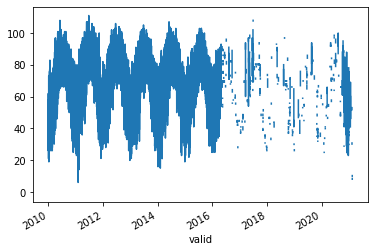

In [ ]:
weather['tmpf'] = pd.to_numeric(weather['tmpf'], errors='coerce')
weather['tmpf'].plot()
plt.show()

#Dropping unnecessary columns

In [ ]:
weather = weather.iloc[:,[1,2,3,4]]

In [ ]:
weather.tail(10)

,valid,tmpf,dwpf,relh
valid,,,,
2021-02-19 23:15:00,2021-02-19 23:15:00,NaN,M,M
2021-02-19 23:20:00,2021-02-19 23:20:00,NaN,M,M
2021-02-19 23:25:00,2021-02-19 23:25:00,NaN,M,M
2021-02-19 23:30:00,2021-02-19 23:30:00,NaN,M,M
2021-02-19 23:35:00,2021-02-19 23:35:00,NaN,M,M
2021-02-19 23:40:00,2021-02-19 23:40:00,NaN,M,M
2021-02-19 23:45:00,2021-02-19 23:45:00,NaN,M,M
2021-02-19 23:50:00,2021-02-19 23:50:00,NaN,M,M
2021-02-19 23:53:00,2021-02-19 23:53:00,44.1,32.00,62.21


# Resampling the data to hourly resolution

As we can see from the ouput of previous line, the records are not seperated by a fixed interval of time. The energy data is given in hourly resolution, converting weather data to match the format with the energy data by calculating the max value per hour.

In [ ]:
weather.resample('60min', origin='2010-01-01 00:00:00').max()

,valid,tmpf,dwpf,relh
valid,,,,
2010-01-01 00:00:00,2010-01-01 00:53:00,30.02,24.98,81.27
2010-01-01 01:00:00,2010-01-01 01:53:00,28.04,24.08,84.87
2010-01-01 02:00:00,2010-01-01 02:53:00,26.96,23.00,84.80
2010-01-01 03:00:00,2010-01-01 03:53:00,26.96,23.00,84.80
2010-01-01 04:00:00,2010-01-01 04:53:00,28.04,23.00,81.11
...,...,...,...,...
2021-02-19 19:00:00,2021-02-19 19:55:00,46.90,M,M
2021-02-19 20:00:00,2021-02-19 20:55:00,44.10,M,M
2021-02-19 21:00:00,2021-02-19 21:55:00,43.00,M,M


Converting all the rows in 'valid' column data which are in the format'201x-xx-xx yy:59:59.992' to '201x-xx-xx yy:00:00' by using dt.floor; this will make the Datetime rows in 'valid' column uniform

In [ ]:
weather['valid']=weather['valid'].dt.floor('H')
weather.head()

,valid,tmpf,dwpf,relh
valid,,,,
2010-01-01 00:53:00,2010-01-01 00:00:00,30.02,24.98,81.27
2010-01-01 01:53:00,2010-01-01 01:00:00,28.04,24.08,84.87
2010-01-01 02:53:00,2010-01-01 02:00:00,26.96,23.00,84.80
2010-01-01 03:53:00,2010-01-01 03:00:00,26.96,23.00,84.80
2010-01-01 04:53:00,2010-01-01 04:00:00,28.04,23.00,81.11


#Sampling the data

In [ ]:
#sampling the data to get the records between 2011 to 2014
weather_sampled = weather[weather.valid.between('2011-01-01', '2014-12-31')]
weather_sampled.head()

,valid,tmpf,dwpf,relh
valid,,,,
2011-01-01 00:53:00,2011-01-01 00:00:00,32.00,17.96,55.72
2011-01-01 01:53:00,2011-01-01 01:00:00,33.08,19.04,55.89
2011-01-01 02:53:00,2011-01-01 02:00:00,33.08,17.96,53.36
2011-01-01 03:53:00,2011-01-01 03:00:00,32.00,19.04,58.37
2011-01-01 04:53:00,2011-01-01 04:00:00,30.02,19.04,63.24


# Replacing 'M' with 'NaN'

In [ ]:
# Replacing M with NaN in order to use ffill 
weather_sampled = weather_sampled.replace('M', np.NaN)
weather_sampled.tail()

,valid,tmpf,dwpf,relh
valid,,,,
2014-12-30 23:14:00,2014-12-30 23:00:00,24.08,24.08,100.00
2014-12-30 23:32:00,2014-12-30 23:00:00,24.08,24.08,100.00
2014-12-30 23:49:00,2014-12-30 23:00:00,24.80,24.80,100.00
2014-12-30 23:53:00,2014-12-30 23:00:00,24.08,24.08,100.00
2014-12-31 00:53:00,2014-12-31 00:00:00,23.00,23.00,100.00


In [ ]:
weather_sampled.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 38167 entries, 2011-01-01 00:53:00 to 2014-12-31 00:53:00
Data columns (total 4 columns):
 #   Column  Non-Null Count  Dtype         
---  ------  --------------  -----         
 0   valid   38167 non-null  datetime64[ns]
 1   tmpf    37966 non-null  float64       
 2   dwpf    37959 non-null  object        
 3   relh    37641 non-null  object        
dtypes: datetime64[ns](1), float64(1), object(2)
memory usage: 1.5+ MB


#Changing datatypes of the columns

In [ ]:
# Now that we replaced M with NaN, the columns can be converted to numeric 
weather_sampled['tmpf'] = pd.to_numeric(weather_sampled['tmpf'])
weather_sampled['dwpf'] = pd.to_numeric(weather_sampled['dwpf'])
weather_sampled['relh'] = pd.to_numeric(weather_sampled['relh'])

weather_sampled.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 38167 entries, 2011-01-01 00:53:00 to 2014-12-31 00:53:00
Data columns (total 4 columns):
 #   Column  Non-Null Count  Dtype         
---  ------  --------------  -----         
 0   valid   38167 non-null  datetime64[ns]
 1   tmpf    37966 non-null  float64       
 2   dwpf    37959 non-null  float64       
 3   relh    37641 non-null  float64       
dtypes: datetime64[ns](1), float64(3)
memory usage: 1.5 MB


In [ ]:
#Using ffill and bfill to impute the missing values
weather_sampled = weather_sampled.fillna(method='ffill').fillna(method='bfill')
weather_sampled.tail()

,valid,tmpf,dwpf,relh
valid,,,,
2014-12-30 23:14:00,2014-12-30 23:00:00,24.08,24.08,100.0
2014-12-30 23:32:00,2014-12-30 23:00:00,24.08,24.08,100.0
2014-12-30 23:49:00,2014-12-30 23:00:00,24.80,24.80,100.0
2014-12-30 23:53:00,2014-12-30 23:00:00,24.08,24.08,100.0
2014-12-31 00:53:00,2014-12-31 00:00:00,23.00,23.00,100.0


In [ ]:
weather_sampled.head()

,valid,tmpf,dwpf,relh
valid,,,,
2011-01-01 00:53:00,2011-01-01 00:00:00,32.00,17.96,55.72
2011-01-01 01:53:00,2011-01-01 01:00:00,33.08,19.04,55.89
2011-01-01 02:53:00,2011-01-01 02:00:00,33.08,17.96,53.36
2011-01-01 03:53:00,2011-01-01 03:00:00,32.00,19.04,58.37
2011-01-01 04:53:00,2011-01-01 04:00:00,30.02,19.04,63.24


In [ ]:
#double checking if there are any missing values left in the data
weather_sampled.isnull().sum()

valid    0
tmpf     0
dwpf     0
relh     0
dtype: int64

All the missing values have been imputed.

#Merging the datasets together

In order to merge both the datasets on date column, renaming the 'valid' column in weather data to 'Date'

In [ ]:
weather_sampled.rename(index=str,columns={'valid':'Date'},inplace=True)
weather_sampled.info()

<class 'pandas.core.frame.DataFrame'>
Index: 38167 entries, 2011-01-01 00:53:00 to 2014-12-31 00:53:00
Data columns (total 4 columns):
 #   Column  Non-Null Count  Dtype         
---  ------  --------------  -----         
 0   Date    38167 non-null  datetime64[ns]
 1   tmpf    38167 non-null  float64       
 2   dwpf    38167 non-null  float64       
 3   relh    38167 non-null  float64       
dtypes: datetime64[ns](1), float64(3)
memory usage: 1.5+ MB


In [ ]:
# Now, merging both the datsets together
data = pd.merge(energy_sampled, weather_sampled, on = 'Date')

In [ ]:
data.head(25)

,Date,MWh,tmpf,dwpf,relh
0,2011-01-01 00:00:00,28496.388850,32.00,17.96,55.72
1,2011-01-01 01:00:00,27662.443480,33.08,19.04,55.89
2,2011-01-01 02:00:00,27250.044715,33.08,17.96,53.36
3,2011-01-01 03:00:00,26783.226081,32.00,19.04,58.37
4,2011-01-01 04:00:00,26676.468490,30.02,19.04,63.24
5,2011-01-01 05:00:00,26868.802537,32.00,21.02,63.51
6,2011-01-01 06:00:00,27640.755062,33.08,21.02,60.81
7,2011-01-01 07:00:00,28768.878874,33.08,17.96,53.36
8,2011-01-01 08:00:00,29580.535108,33.98,14.00,43.34
9,2011-01-01 09:00:00,30454.860274,35.06,6.98,30.35


# Missing Values 

In [ ]:
# checking if there are any missing values in final dataset 
data.isnull().sum()

Date    0
MWh     0
tmpf    0
dwpf    0
relh    0
dtype: int64

There are no missing values in our final dataset.

#Outlier Detection
Plotting the data to check if all the data cleaning opeations were successful and there are no outliers

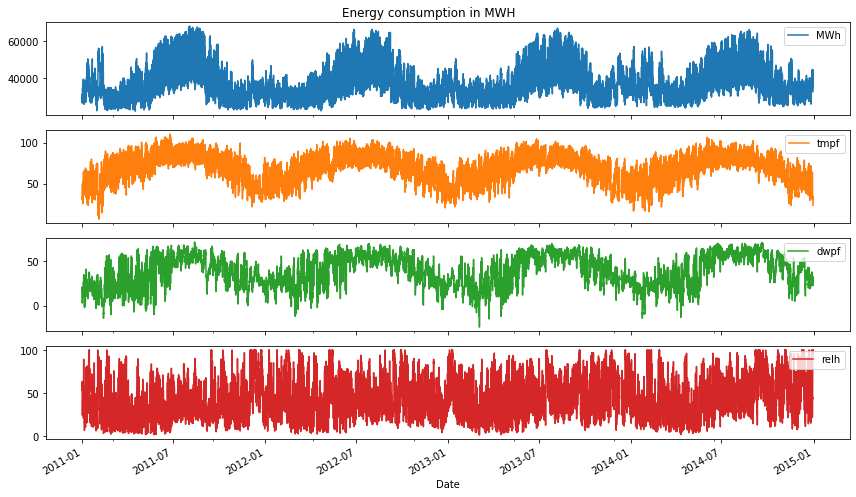

In [ ]:
import matplotlib.pyplot as plt

data.set_index('Date')[['MWh', 'tmpf', 'dwpf', 'relh']].plot(subplots = True, figsize = (12,7))
[ax.legend(loc = 1) for ax in plt.gcf().axes]
plt.suptitle('Energy consumption in MWH')
plt.tight_layout()
plt.subplots_adjust(top = 0.95)

# Feature Engineering

For feature engineering, we applied the same technique as follows for `Date` column in training and test sets.

Since `Date` column provides valuable information for the model target in the time series dataset, we extracted the parts of the date into different columns. It includes Month, Hour, Day, and Weekday. Both of them were used for EDA to explore the relationship between energy consumption and weather-related data and modeling. As the `Weekday` column ranges from 0 to 6, we did mapping to show the actual name of Weekday. We also used this variable to define `Weekend` or not and transformed it into binary form, 0 and 1. The machine learning algorithms can easily understand the information that is given from the transformed columns.

However, we created a 5-hour, 10-hour, 24-hour, and 48-hour rolling average for `tmpf` and ` dwpf`. The reason for creating a rolling average is to remove noise and better expose the signal of the underlying causal processes.

In [ ]:
data.head(5)

,Date,MWh,tmpf,dwpf,relh
0,2011-01-01 00:00:00,28496.388850,32.00,17.96,55.72
1,2011-01-01 01:00:00,27662.443480,33.08,19.04,55.89
2,2011-01-01 02:00:00,27250.044715,33.08,17.96,53.36
3,2011-01-01 03:00:00,26783.226081,32.00,19.04,58.37
4,2011-01-01 04:00:00,26676.468490,30.02,19.04,63.24


In [ ]:
# extract Month, Hour, Day & Weekday from the datetime variable
data['Month'] = data['Date'].dt.month # extract the Month
data['Hour'] = data['Date'].dt.hour # extract the Hour
data['Day'] = data['Date'].dt.day # extract the Day
data['Weekday'] = data['Date'].dt.dayofweek # extract the Weekday
data.head(30)

,Date,MWh,tmpf,dwpf,relh,Month,Hour,Day,Weekday
0,2011-01-01 00:00:00,28496.388850,32.00,17.96,55.72,1,0,1,5
1,2011-01-01 01:00:00,27662.443480,33.08,19.04,55.89,1,1,1,5
2,2011-01-01 02:00:00,27250.044715,33.08,17.96,53.36,1,2,1,5
3,2011-01-01 03:00:00,26783.226081,32.00,19.04,58.37,1,3,1,5
4,2011-01-01 04:00:00,26676.468490,30.02,19.04,63.24,1,4,1,5
5,2011-01-01 05:00:00,26868.802537,32.00,21.02,63.51,1,5,1,5
6,2011-01-01 06:00:00,27640.755062,33.08,21.02,60.81,1,6,1,5
7,2011-01-01 07:00:00,28768.878874,33.08,17.96,53.36,1,7,1,5
8,2011-01-01 08:00:00,29580.535108,33.98,14.00,43.34,1,8,1,5
9,2011-01-01 09:00:00,30454.860274,35.06,6.98,30.35,1,9,1,5


In [ ]:
# do mapping to show the actual name of weekday
data['Weekday_Name'] = data['Weekday']
replace_map = {'Weekday_Name': {0 :'Monday', 1 :'Tuesday', 2: 'Wednesday', 3:'Thursday', 4: 'Friday', 5 :'Saturday', 6: 'Sunday'}}
data.replace(replace_map, inplace = True)
data.head()

,Date,MWh,tmpf,dwpf,relh,Month,Hour,Day,Weekday,Weekday_Name
0,2011-01-01 00:00:00,28496.388850,32.00,17.96,55.72,1,0,1,5,Saturday
1,2011-01-01 01:00:00,27662.443480,33.08,19.04,55.89,1,1,1,5,Saturday
2,2011-01-01 02:00:00,27250.044715,33.08,17.96,53.36,1,2,1,5,Saturday
3,2011-01-01 03:00:00,26783.226081,32.00,19.04,58.37,1,3,1,5,Saturday
4,2011-01-01 04:00:00,26676.468490,30.02,19.04,63.24,1,4,1,5,Saturday


In [ ]:
# show weekend or not into binary
data = data.assign(Weekend = lambda df: df['Weekday'].apply(lambda day: 'Yes' if day >4 else 'No'))

In [ ]:
# switch it into 0 or 1
data['Weekend_code'] = data['Weekend']
replace_map = {'Weekend_code': {'No':0,'Yes':1}}
data.replace(replace_map, inplace = True)
data.head()

,Date,MWh,tmpf,dwpf,relh,Month,Hour,Day,Weekday,Weekday_Name,Weekend,Weekend_code
0,2011-01-01 00:00:00,28496.388850,32.00,17.96,55.72,1,0,1,5,Saturday,Yes,1
1,2011-01-01 01:00:00,27662.443480,33.08,19.04,55.89,1,1,1,5,Saturday,Yes,1
2,2011-01-01 02:00:00,27250.044715,33.08,17.96,53.36,1,2,1,5,Saturday,Yes,1
3,2011-01-01 03:00:00,26783.226081,32.00,19.04,58.37,1,3,1,5,Saturday,Yes,1
4,2011-01-01 04:00:00,26676.468490,30.02,19.04,63.24,1,4,1,5,Saturday,Yes,1


In [ ]:
# create 5 hours rolling average for weather data
data['tmpf_5hr_roll_avg'] = data.iloc[:,2].rolling(window=5).mean()
data['dwpf_5hr_roll_avg'] = data.iloc[:,3].rolling(window=5).mean()
data.head(6)

,Date,MWh,tmpf,dwpf,relh,Month,Hour,Day,Weekday,Weekday_Name,Weekend,Weekend_code,tmpf_5hr_roll_avg,dwpf_5hr_roll_avg
0,2011-01-01 00:00:00,28496.388850,32.00,17.96,55.72,1,0,1,5,Saturday,Yes,1,NaN,NaN
1,2011-01-01 01:00:00,27662.443480,33.08,19.04,55.89,1,1,1,5,Saturday,Yes,1,NaN,NaN
2,2011-01-01 02:00:00,27250.044715,33.08,17.96,53.36,1,2,1,5,Saturday,Yes,1,NaN,NaN
3,2011-01-01 03:00:00,26783.226081,32.00,19.04,58.37,1,3,1,5,Saturday,Yes,1,NaN,NaN
4,2011-01-01 04:00:00,26676.468490,30.02,19.04,63.24,1,4,1,5,Saturday,Yes,1,32.036,18.608
5,2011-01-01 05:00:00,26868.802537,32.00,21.02,63.51,1,5,1,5,Saturday,Yes,1,32.036,19.220


In [ ]:
# create 10 hours rolling average for weather data
data['tmpf_10hr_roll_avg'] = data.iloc[:,2].rolling(window=10).mean()
data['dwpf_10hr_roll_avg'] = data.iloc[:,3].rolling(window=10).mean()
data.head(6)

,Date,MWh,tmpf,dwpf,relh,Month,Hour,Day,Weekday,Weekday_Name,Weekend,Weekend_code,tmpf_5hr_roll_avg,dwpf_5hr_roll_avg,tmpf_10hr_roll_avg,dwpf_10hr_roll_avg
0,2011-01-01 00:00:00,28496.388850,32.00,17.96,55.72,1,0,1,5,Saturday,Yes,1,NaN,NaN,NaN,NaN
1,2011-01-01 01:00:00,27662.443480,33.08,19.04,55.89,1,1,1,5,Saturday,Yes,1,NaN,NaN,NaN,NaN
2,2011-01-01 02:00:00,27250.044715,33.08,17.96,53.36,1,2,1,5,Saturday,Yes,1,NaN,NaN,NaN,NaN
3,2011-01-01 03:00:00,26783.226081,32.00,19.04,58.37,1,3,1,5,Saturday,Yes,1,NaN,NaN,NaN,NaN
4,2011-01-01 04:00:00,26676.468490,30.02,19.04,63.24,1,4,1,5,Saturday,Yes,1,32.036,18.608,NaN,NaN
5,2011-01-01 05:00:00,26868.802537,32.00,21.02,63.51,1,5,1,5,Saturday,Yes,1,32.036,19.220,NaN,NaN


In [ ]:
# create 24 hours rolling average for weather data
data['tmpf_24hr_roll_avg'] = data.iloc[:,2].rolling(window=24).mean()
data['dwpf_24hr_roll_avg'] = data.iloc[:,3].rolling(window=24).mean()
data.head(6)

,Date,MWh,tmpf,dwpf,relh,Month,Hour,Day,Weekday,Weekday_Name,Weekend,Weekend_code,tmpf_5hr_roll_avg,dwpf_5hr_roll_avg,tmpf_10hr_roll_avg,dwpf_10hr_roll_avg,tmpf_24hr_roll_avg,dwpf_24hr_roll_avg
0,2011-01-01 00:00:00,28496.388850,32.00,17.96,55.72,1,0,1,5,Saturday,Yes,1,NaN,NaN,NaN,NaN,NaN,NaN
1,2011-01-01 01:00:00,27662.443480,33.08,19.04,55.89,1,1,1,5,Saturday,Yes,1,NaN,NaN,NaN,NaN,NaN,NaN
2,2011-01-01 02:00:00,27250.044715,33.08,17.96,53.36,1,2,1,5,Saturday,Yes,1,NaN,NaN,NaN,NaN,NaN,NaN
3,2011-01-01 03:00:00,26783.226081,32.00,19.04,58.37,1,3,1,5,Saturday,Yes,1,NaN,NaN,NaN,NaN,NaN,NaN
4,2011-01-01 04:00:00,26676.468490,30.02,19.04,63.24,1,4,1,5,Saturday,Yes,1,32.036,18.608,NaN,NaN,NaN,NaN
5,2011-01-01 05:00:00,26868.802537,32.00,21.02,63.51,1,5,1,5,Saturday,Yes,1,32.036,19.220,NaN,NaN,NaN,NaN


In [ ]:
# create 48 hours rolling average for weather data
data['tmpf_48hr_roll_avg'] = data.iloc[:,2].rolling(window=48).mean()
data['dwpf_48hr_roll_avg'] = data.iloc[:,3].rolling(window=48).mean()
data.head(5)

,Date,MWh,tmpf,dwpf,relh,Month,Hour,Day,Weekday,Weekday_Name,Weekend,Weekend_code,tmpf_5hr_roll_avg,dwpf_5hr_roll_avg,tmpf_10hr_roll_avg,dwpf_10hr_roll_avg,tmpf_24hr_roll_avg,dwpf_24hr_roll_avg,tmpf_48hr_roll_avg,dwpf_48hr_roll_avg
0,2011-01-01 00:00:00,28496.388850,32.00,17.96,55.72,1,0,1,5,Saturday,Yes,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2011-01-01 01:00:00,27662.443480,33.08,19.04,55.89,1,1,1,5,Saturday,Yes,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,2011-01-01 02:00:00,27250.044715,33.08,17.96,53.36,1,2,1,5,Saturday,Yes,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,2011-01-01 03:00:00,26783.226081,32.00,19.04,58.37,1,3,1,5,Saturday,Yes,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,2011-01-01 04:00:00,26676.468490,30.02,19.04,63.24,1,4,1,5,Saturday,Yes,1,32.036,18.608,NaN,NaN,NaN,NaN,NaN,NaN


In [ ]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 38172 entries, 0 to 38171
Data columns (total 20 columns):
 #   Column              Non-Null Count  Dtype         
---  ------              --------------  -----         
 0   Date                38172 non-null  datetime64[ns]
 1   MWh                 38172 non-null  float64       
 2   tmpf                38172 non-null  float64       
 3   dwpf                38172 non-null  float64       
 4   relh                38172 non-null  float64       
 5   Month               38172 non-null  int64         
 6   Hour                38172 non-null  int64         
 7   Day                 38172 non-null  int64         
 8   Weekday             38172 non-null  int64         
 9   Weekday_Name        38172 non-null  object        
 10  Weekend             38172 non-null  object        
 11  Weekend_code        38172 non-null  int64         
 12  tmpf_5hr_roll_avg   38168 non-null  float64       
 13  dwpf_5hr_roll_avg   38168 non-null  float64   

# Sampling 2015 data (Target)

In [ ]:
#sampling the data to get the records from 2015
target_e_sampled = energy[energy.Date.between('2015-01-01', '2015-12-31')]
target_e_sampled.head()

,Date,MWh
43823,2015-01-01 00:00:00,40707.660350
43824,2015-01-01 01:00:00,39624.861027
43825,2015-01-01 02:00:00,39013.544802
43826,2015-01-01 03:00:00,38566.541927
43827,2015-01-01 04:00:00,38488.338511


In [ ]:
#sampling the data to get the records from 2015
target_weather_sampled = weather[weather.valid.between('2015-01-01', '2015-12-31')]
target_weather_sampled.head()

,valid,tmpf,dwpf,relh
valid,,,,
2015-01-01 00:03:00,2015-01-01 00:00:00,21.02,21.02,100.00
2015-01-01 00:26:00,2015-01-01 00:00:00,21.02,21.02,100.00
2015-01-01 00:53:00,2015-01-01 00:00:00,21.02,21.02,100.00
2015-01-01 01:53:00,2015-01-01 01:00:00,21.92,21.02,96.26
2015-01-01 02:04:00,2015-01-01 02:00:00,21.92,21.02,96.26


In [ ]:
#resampling the data to hourly resolution
target_weather_sampled.resample('60min', origin='2015-01-01 00:00:00').max()

,valid,tmpf,dwpf,relh
valid,,,,
2015-01-01 00:00:00,2015-01-01 00:00:00,21.02,21.02,100.00
2015-01-01 01:00:00,2015-01-01 01:00:00,21.92,21.02,96.26
2015-01-01 02:00:00,2015-01-01 02:00:00,21.92,21.02,96.26
2015-01-01 03:00:00,2015-01-01 03:00:00,21.92,21.92,96.26
2015-01-01 04:00:00,2015-01-01 04:00:00,23.00,21.92,95.55
...,...,...,...,...
2015-12-30 20:00:00,2015-12-30 20:00:00,44.96,33.98,65.18
2015-12-30 21:00:00,2015-12-30 21:00:00,42.98,33.08,67.81
2015-12-30 22:00:00,2015-12-30 22:00:00,41.00,33.98,75.88


In [ ]:
# Replacing M with NaN in order to use ffill 
target_weather_sampled = target_weather_sampled.replace('M', np.NaN)
target_weather_sampled.tail()

,valid,tmpf,dwpf,relh
valid,,,,
2015-12-30 20:53:00,2015-12-30 20:00:00,44.96,33.98,65.18
2015-12-30 21:53:00,2015-12-30 21:00:00,42.98,33.08,67.81
2015-12-30 22:53:00,2015-12-30 22:00:00,41.00,33.98,75.88
2015-12-30 23:53:00,2015-12-30 23:00:00,41.00,33.98,75.88
2015-12-31 00:53:00,2015-12-31 00:00:00,39.92,33.98,79.12


In [ ]:
# Now that we replaced M with NaN, the columns can be converted to numeric 
target_weather_sampled['tmpf'] = pd.to_numeric(target_weather_sampled['tmpf'])
target_weather_sampled['dwpf'] = pd.to_numeric(target_weather_sampled['dwpf'])
target_weather_sampled['relh'] = pd.to_numeric(target_weather_sampled['relh'])

target_weather_sampled.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 10493 entries, 2015-01-01 00:03:00 to 2015-12-31 00:53:00
Data columns (total 4 columns):
 #   Column  Non-Null Count  Dtype         
---  ------  --------------  -----         
 0   valid   10493 non-null  datetime64[ns]
 1   tmpf    10490 non-null  float64       
 2   dwpf    10490 non-null  float64       
 3   relh    10404 non-null  float64       
dtypes: datetime64[ns](1), float64(3)
memory usage: 409.9 KB


In [ ]:
#Using ffill and bfill to impute the missing values
target_weather_sampled = target_weather_sampled.fillna(method='ffill').fillna(method='bfill')
target_weather_sampled.tail()

,valid,tmpf,dwpf,relh
valid,,,,
2015-12-30 20:53:00,2015-12-30 20:00:00,44.96,33.98,65.18
2015-12-30 21:53:00,2015-12-30 21:00:00,42.98,33.08,67.81
2015-12-30 22:53:00,2015-12-30 22:00:00,41.00,33.98,75.88
2015-12-30 23:53:00,2015-12-30 23:00:00,41.00,33.98,75.88
2015-12-31 00:53:00,2015-12-31 00:00:00,39.92,33.98,79.12


In [ ]:
#double checking if there are any missing values left in the data
target_weather_sampled.isnull().sum()

valid    0
tmpf     0
dwpf     0
relh     0
dtype: int64

In [ ]:
#merging
target_weather_sampled.rename(index=str,columns={'valid':'Date'},inplace=True)
target_weather_sampled.info()

<class 'pandas.core.frame.DataFrame'>
Index: 10493 entries, 2015-01-01 00:03:00 to 2015-12-31 00:53:00
Data columns (total 4 columns):
 #   Column  Non-Null Count  Dtype         
---  ------  --------------  -----         
 0   Date    10493 non-null  datetime64[ns]
 1   tmpf    10493 non-null  float64       
 2   dwpf    10493 non-null  float64       
 3   relh    10493 non-null  float64       
dtypes: datetime64[ns](1), float64(3)
memory usage: 409.9+ KB


In [ ]:
# Now, merging both the datsets together
target_data = pd.merge(target_e_sampled, target_weather_sampled, on = 'Date')

In [ ]:
target_data.head()

,Date,MWh,tmpf,dwpf,relh
0,2015-01-01 00:00:00,40707.660350,21.02,21.02,100.00
1,2015-01-01 00:00:00,40707.660350,21.02,21.02,100.00
2,2015-01-01 00:00:00,40707.660350,21.02,21.02,100.00
3,2015-01-01 01:00:00,39624.861027,21.92,21.02,96.26
4,2015-01-01 02:00:00,39013.544802,21.92,21.02,96.26


# Feature Engineering for 2015 data

In [ ]:
# extract Month, Hour, Day & Weekday from the datetime variable
target_data['Month'] = target_data['Date'].dt.month # extract the Month
target_data['Hour'] = target_data['Date'].dt.hour # extract the Hour
target_data['Day'] = target_data['Date'].dt.day # extract the Day
target_data['Weekday'] = target_data['Date'].dt.dayofweek # extract the Weekday
target_data.head(30)

,Date,MWh,tmpf,dwpf,relh,Month,Hour,Day,Weekday
0,2015-01-01 00:00:00,40707.660350,21.02,21.02,100.00,1,0,1,3
1,2015-01-01 00:00:00,40707.660350,21.02,21.02,100.00,1,0,1,3
2,2015-01-01 00:00:00,40707.660350,21.02,21.02,100.00,1,0,1,3
3,2015-01-01 01:00:00,39624.861027,21.92,21.02,96.26,1,1,1,3
4,2015-01-01 02:00:00,39013.544802,21.92,21.02,96.26,1,2,1,3
5,2015-01-01 02:00:00,39013.544802,21.92,21.02,96.26,1,2,1,3
6,2015-01-01 03:00:00,38566.541927,21.92,21.92,100.00,1,3,1,3
7,2015-01-01 03:00:00,38566.541927,21.92,21.92,100.00,1,3,1,3
8,2015-01-01 03:00:00,38566.541927,21.92,21.92,100.00,1,3,1,3
9,2015-01-01 03:00:00,38566.541927,21.92,21.02,96.26,1,3,1,3


In [ ]:
# do mapping to show the actual name of weekday
target_data['Weekday_Name'] = target_data['Weekday']
replace_map = {'Weekday_Name': {0 :'Monday', 1 :'Tuesday', 2: 'Wednesday', 3:'Thursday', 4: 'Friday', 5 :'Saturday', 6: 'Sunday'}}
target_data.replace(replace_map, inplace = True)
target_data.head()

,Date,MWh,tmpf,dwpf,relh,Month,Hour,Day,Weekday,Weekday_Name
0,2015-01-01 00:00:00,40707.660350,21.02,21.02,100.00,1,0,1,3,Thursday
1,2015-01-01 00:00:00,40707.660350,21.02,21.02,100.00,1,0,1,3,Thursday
2,2015-01-01 00:00:00,40707.660350,21.02,21.02,100.00,1,0,1,3,Thursday
3,2015-01-01 01:00:00,39624.861027,21.92,21.02,96.26,1,1,1,3,Thursday
4,2015-01-01 02:00:00,39013.544802,21.92,21.02,96.26,1,2,1,3,Thursday


In [ ]:
target_data = target_data.iloc[2:]

In [ ]:
# show weekend or not into binary
target_data = target_data.assign(Weekend = lambda df: df['Weekday'].apply(lambda day: 'Yes' if day >4 else 'No'))

In [ ]:
# switch it into 0 or 1
target_data['Weekend_code'] = target_data['Weekend']
replace_map = {'Weekend_code': {'No':0, 'Yes':1}}
target_data.replace(replace_map, inplace = True)
target_data.head()

,Date,MWh,tmpf,dwpf,relh,Month,Hour,Day,Weekday,Weekday_Name,Weekend,Weekend_code
2,2015-01-01 00:00:00,40707.660350,21.02,21.02,100.00,1,0,1,3,Thursday,No,0
3,2015-01-01 01:00:00,39624.861027,21.92,21.02,96.26,1,1,1,3,Thursday,No,0
4,2015-01-01 02:00:00,39013.544802,21.92,21.02,96.26,1,2,1,3,Thursday,No,0
5,2015-01-01 02:00:00,39013.544802,21.92,21.02,96.26,1,2,1,3,Thursday,No,0
6,2015-01-01 03:00:00,38566.541927,21.92,21.92,100.00,1,3,1,3,Thursday,No,0


In [ ]:
# create 5 hours rolling average for weather data
target_data['tmpf_5hr_roll_avg'] = target_data.iloc[:,2].rolling(window=5).mean()
target_data['dwpf_5hr_roll_avg'] = target_data.iloc[:,3].rolling(window=5).mean()
data.head(6)

,Date,MWh,tmpf,dwpf,relh,Month,Hour,Day,Weekday,Weekday_Name,Weekend,Weekend_code,tmpf_5hr_roll_avg,dwpf_5hr_roll_avg,tmpf_10hr_roll_avg,dwpf_10hr_roll_avg,tmpf_24hr_roll_avg,dwpf_24hr_roll_avg,tmpf_48hr_roll_avg,dwpf_48hr_roll_avg
0,2011-01-01 00:00:00,28496.388850,32.00,17.96,55.72,1,0,1,5,Saturday,Yes,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2011-01-01 01:00:00,27662.443480,33.08,19.04,55.89,1,1,1,5,Saturday,Yes,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,2011-01-01 02:00:00,27250.044715,33.08,17.96,53.36,1,2,1,5,Saturday,Yes,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,2011-01-01 03:00:00,26783.226081,32.00,19.04,58.37,1,3,1,5,Saturday,Yes,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,2011-01-01 04:00:00,26676.468490,30.02,19.04,63.24,1,4,1,5,Saturday,Yes,1,32.036,18.608,NaN,NaN,NaN,NaN,NaN,NaN
5,2011-01-01 05:00:00,26868.802537,32.00,21.02,63.51,1,5,1,5,Saturday,Yes,1,32.036,19.220,NaN,NaN,NaN,NaN,NaN,NaN


In [ ]:
# create 10 hours rolling average for weather data
target_data['tmpf_10hr_roll_avg'] = target_data.iloc[:,2].rolling(window=10).mean()
target_data['dwpf_10hr_roll_avg'] = target_data.iloc[:,3].rolling(window=10).mean()
data.head(6)

,Date,MWh,tmpf,dwpf,relh,Month,Hour,Day,Weekday,Weekday_Name,Weekend,Weekend_code,tmpf_5hr_roll_avg,dwpf_5hr_roll_avg,tmpf_10hr_roll_avg,dwpf_10hr_roll_avg,tmpf_24hr_roll_avg,dwpf_24hr_roll_avg,tmpf_48hr_roll_avg,dwpf_48hr_roll_avg
0,2011-01-01 00:00:00,28496.388850,32.00,17.96,55.72,1,0,1,5,Saturday,Yes,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2011-01-01 01:00:00,27662.443480,33.08,19.04,55.89,1,1,1,5,Saturday,Yes,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,2011-01-01 02:00:00,27250.044715,33.08,17.96,53.36,1,2,1,5,Saturday,Yes,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,2011-01-01 03:00:00,26783.226081,32.00,19.04,58.37,1,3,1,5,Saturday,Yes,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,2011-01-01 04:00:00,26676.468490,30.02,19.04,63.24,1,4,1,5,Saturday,Yes,1,32.036,18.608,NaN,NaN,NaN,NaN,NaN,NaN
5,2011-01-01 05:00:00,26868.802537,32.00,21.02,63.51,1,5,1,5,Saturday,Yes,1,32.036,19.220,NaN,NaN,NaN,NaN,NaN,NaN


In [ ]:
# create 24 hours rolling average for weather data
target_data['tmpf_24hr_roll_avg'] = target_data.iloc[:,2].rolling(window=24).mean()
target_data['dwpf_24hr_roll_avg'] = target_data.iloc[:,3].rolling(window=24).mean()
data.head(6)

,Date,MWh,tmpf,dwpf,relh,Month,Hour,Day,Weekday,Weekday_Name,Weekend,Weekend_code,tmpf_5hr_roll_avg,dwpf_5hr_roll_avg,tmpf_10hr_roll_avg,dwpf_10hr_roll_avg,tmpf_24hr_roll_avg,dwpf_24hr_roll_avg,tmpf_48hr_roll_avg,dwpf_48hr_roll_avg
0,2011-01-01 00:00:00,28496.388850,32.00,17.96,55.72,1,0,1,5,Saturday,Yes,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2011-01-01 01:00:00,27662.443480,33.08,19.04,55.89,1,1,1,5,Saturday,Yes,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,2011-01-01 02:00:00,27250.044715,33.08,17.96,53.36,1,2,1,5,Saturday,Yes,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,2011-01-01 03:00:00,26783.226081,32.00,19.04,58.37,1,3,1,5,Saturday,Yes,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,2011-01-01 04:00:00,26676.468490,30.02,19.04,63.24,1,4,1,5,Saturday,Yes,1,32.036,18.608,NaN,NaN,NaN,NaN,NaN,NaN
5,2011-01-01 05:00:00,26868.802537,32.00,21.02,63.51,1,5,1,5,Saturday,Yes,1,32.036,19.220,NaN,NaN,NaN,NaN,NaN,NaN


In [ ]:
# create 48 hours rolling average for weather data
target_data['tmpf_48hr_roll_avg'] = target_data.iloc[:,2].rolling(window=48).mean()
target_data['dwpf_48hr_roll_avg'] = target_data.iloc[:,3].rolling(window=48).mean()
data.head(6)

,Date,MWh,tmpf,dwpf,relh,Month,Hour,Day,Weekday,Weekday_Name,Weekend,Weekend_code,tmpf_5hr_roll_avg,dwpf_5hr_roll_avg,tmpf_10hr_roll_avg,dwpf_10hr_roll_avg,tmpf_24hr_roll_avg,dwpf_24hr_roll_avg,tmpf_48hr_roll_avg,dwpf_48hr_roll_avg
0,2011-01-01 00:00:00,28496.388850,32.00,17.96,55.72,1,0,1,5,Saturday,Yes,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2011-01-01 01:00:00,27662.443480,33.08,19.04,55.89,1,1,1,5,Saturday,Yes,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,2011-01-01 02:00:00,27250.044715,33.08,17.96,53.36,1,2,1,5,Saturday,Yes,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,2011-01-01 03:00:00,26783.226081,32.00,19.04,58.37,1,3,1,5,Saturday,Yes,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,2011-01-01 04:00:00,26676.468490,30.02,19.04,63.24,1,4,1,5,Saturday,Yes,1,32.036,18.608,NaN,NaN,NaN,NaN,NaN,NaN
5,2011-01-01 05:00:00,26868.802537,32.00,21.02,63.51,1,5,1,5,Saturday,Yes,1,32.036,19.220,NaN,NaN,NaN,NaN,NaN,NaN


In [ ]:
target_data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 10492 entries, 2 to 10493
Data columns (total 20 columns):
 #   Column              Non-Null Count  Dtype         
---  ------              --------------  -----         
 0   Date                10492 non-null  datetime64[ns]
 1   MWh                 10492 non-null  float64       
 2   tmpf                10492 non-null  float64       
 3   dwpf                10492 non-null  float64       
 4   relh                10492 non-null  float64       
 5   Month               10492 non-null  int64         
 6   Hour                10492 non-null  int64         
 7   Day                 10492 non-null  int64         
 8   Weekday             10492 non-null  int64         
 9   Weekday_Name        10492 non-null  object        
 10  Weekend             10492 non-null  object        
 11  Weekend_code        10492 non-null  int64         
 12  tmpf_5hr_roll_avg   10488 non-null  float64       
 13  dwpf_5hr_roll_avg   10488 non-null  float64   

# Exploratory Data Analysis and Statistics

## Line Chart of Temperature vs. MWh By Month From 2011 to 2014

In [ ]:
# group the temperature variable by month from 2011 to 2014
month = data.groupby('Month') # group by month
month_tmpf = month['tmpf'].agg(['mean','min','max']).reset_index() # aggregate the tmpf for average, min and max and flatten the index
month_tmpf = pd.DataFrame(month_tmpf) # set in the dataframe

month2 = data.groupby('Month') # group by month
month_mwh = month2['MWh'].agg(['mean','min','max']).reset_index() # aggregate the MWh for average, min and max and flatten the index
month_mwh = pd.DataFrame(month_mwh) # set in the dataframe

Text(0, 0.5, 'Megawatt-hour Consumption')

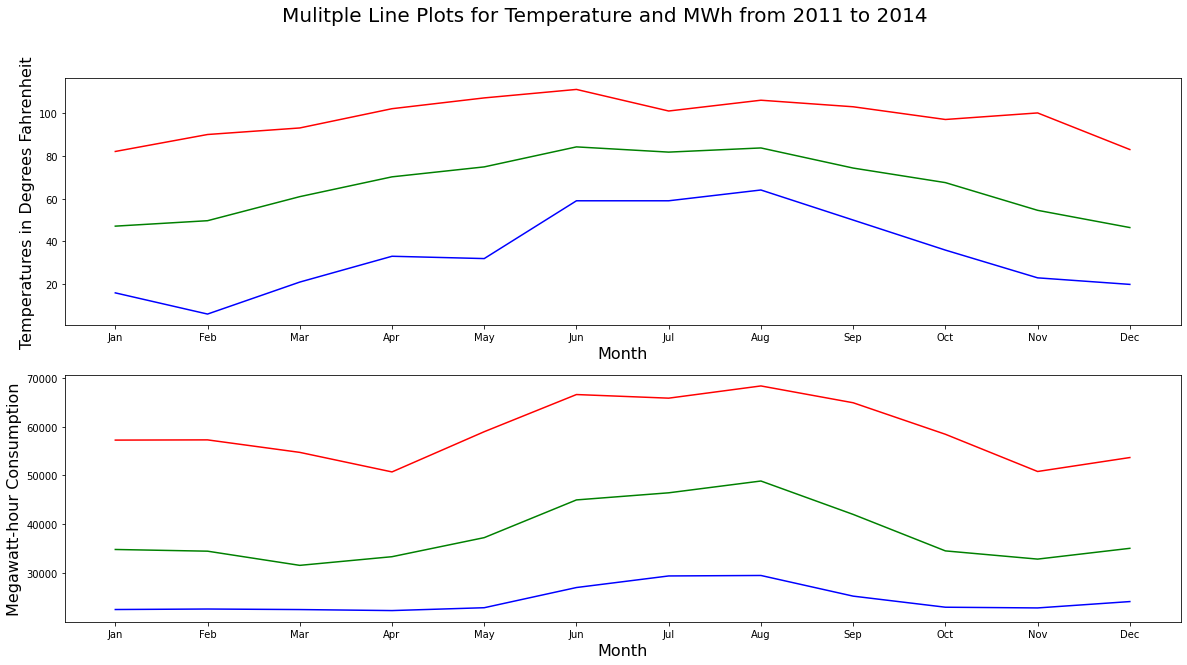

In [ ]:
fig, axes = plt.subplots(2, 1, figsize=(20, 10)) # create subplot
fig.suptitle('Mulitple Line Plots for Temperature and MWh from 2011 to 2014', fontsize=20) # set the title for this plot

# first lines plot for average, min and max temperature
x1 = month_tmpf.Month

y1 = month_tmpf['mean']
y2 = month_tmpf['min']
y3 = month_tmpf['max']

axes[0].plot(x1, y1, label='Avg Temp', color='green') # average temperature
axes[0].plot(x1, y2, label='Min Temp', color='blue') # min temperature
axes[0].plot(x1, y3, label='Max Temp', color='red') # max temperature
axes[0].set_xlabel('Month', fontsize=16) # xlabel
axes[0].set_xticks(x1)
axes[0].set_xticklabels(['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec'])
axes[0].set_ylabel('Temperatures in Degrees Fahrenheit', fontsize=16) # ylabel

# second lines plot for average, min and max MWh
x2 = month_mwh.Month

y4 = month_mwh['mean']
y5 = month_mwh['min']
y6 = month_mwh['max']

axes[1].plot(x2, y4, label='Avg Temp', color='green') # average temperature
axes[1].plot(x2, y5, label='Min Temp', color='blue') # min temperature
axes[1].plot(x2, y6, label='Max Temp', color='red') # max temperature
axes[1].set_xlabel('Month', fontsize=16) # xlabel
axes[1].set_xticks(x2)
axes[1].set_xticklabels(['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec'])
axes[1].set_ylabel('Megawatt-hour Consumption', fontsize=16) # ylabel

The line charts show that the residents in Texas consumed more energy in Summer rather than Winter. The statistics table below shows us that the maximum temperature in Texas usually reaches over 100 degrees. The residents may consume more energy for air-conditioning and other cooling systems. However, when the temperature was going down during Spring and Fall, they used less energy relatively. When the temperature was further decreasing in Winter, the consumption has increased steadily for the heating system in the house. The seasonal pattern could help the ERCOT to evaluate the energy demand during different seasons.

## Correlation Heatmap of MWh and Independent Variables

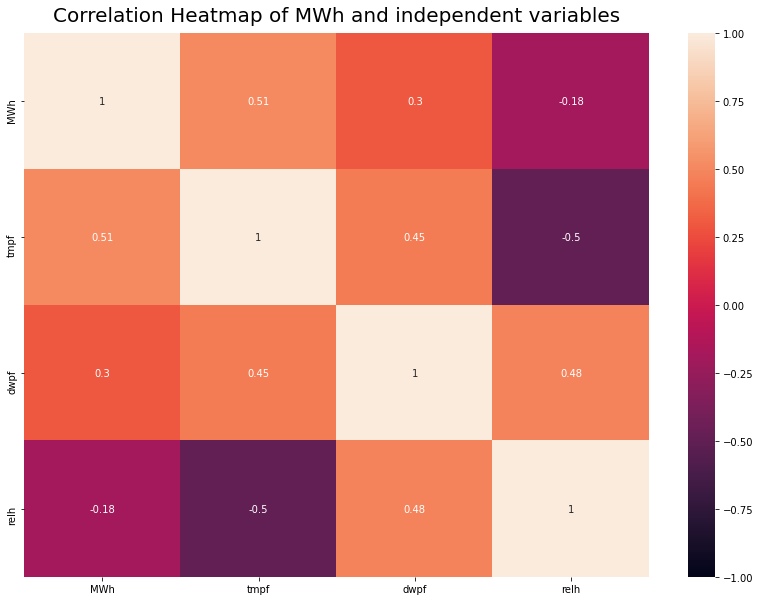

In [ ]:
# exclude the timestamp related variables
data_corr = data.iloc[:,0:5]

# plot the heatmap for the correlation matrix 
plt.figure(figsize=(14, 10)) # set the size
heatmap = sns.heatmap(data_corr.corr(), vmin=-1, vmax=1, annot=True) # plot the heatmap
heatmap.set_title('Correlation Heatmap of MWh and independent variables', fontdict={'fontsize':20}, pad=12) # name the plot
plt.show() # show the plot

This heatmap tells us the correlation between the target variable and other variables. The temperature was a key driver affecting the target variable as it had a higher positive correlation with the target variable. When the temperature increases, the relative humidity was relatively lower. These factors may provide a better understanding for the ERCOT to estimate the energy demand.

## Holidays MWh Usage Boxplot in 2014

In [ ]:
# define Texas holidays dictionary in 2014
tx_holidays2014 = dict({
    1:{1: 'New Year Day',
       19: 'Confederate Memorial Day',
       20: ' Martin Luther King Jr. Day'},
    2:{17: 'President Day'},
    3:{2: 'Texas Independence Day'},
    4:{21: 'San Jacinto Day'},
    5:{26: 'Memorial Day'},
    6:{19: 'Emancipation Day in Texas'},
    7:{4: 'Independence Day'},
    8:{27: 'Lyndon Baines Johnson Day'},
    9:{1: 'Labor Day'},
    11:{11: 'Veterans Day',
        27: 'Thanksgiving Day',
        28: 'Black Friday'},
    12:{24: 'Christmas Eve',
        25: 'Christmas',
        26: 'Day After Christmas'}
})

In [ ]:
# make a copy of data and define holidays in 2014
year2014 = data.copy()
year2014['Year'] = year2014['Date'].dt.year # extract 2014
year2014 = year2014[year2014['Year'] == 2014]
year2014 = year2014.assign(Event = lambda data: data['Date'].apply(lambda day: (tx_holidays2014.get(day.month)).get(day.day)\
                                                if tx_holidays2014.get(day.month) != None \
                                                and (tx_holidays2014.get(day.month)).get(day.day) != None \
                                                else 'Normal'))

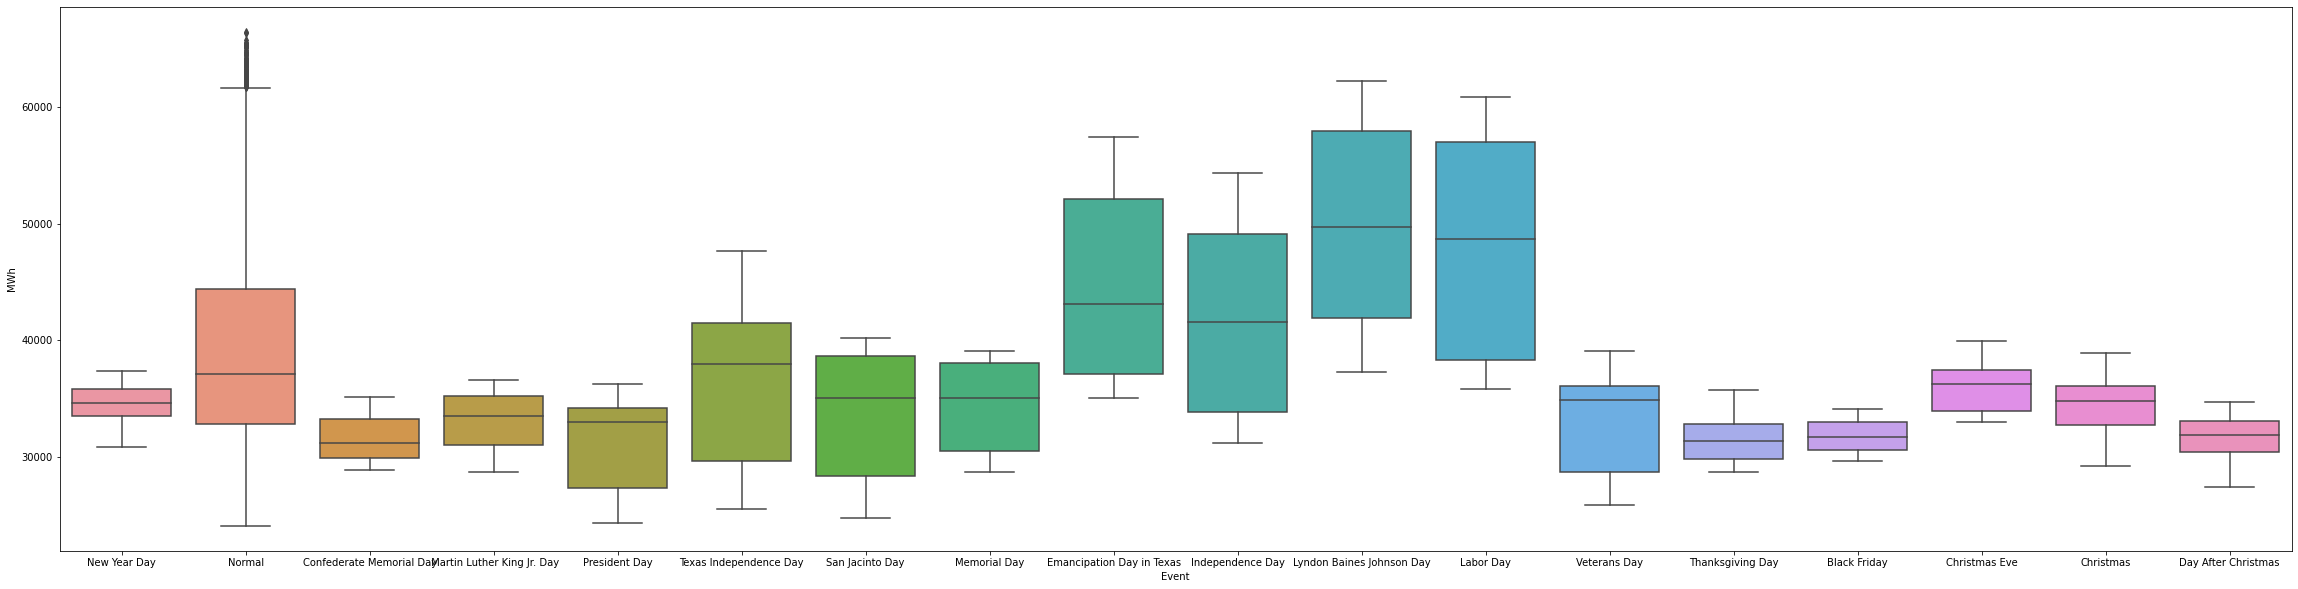

In [ ]:
# plot the MWh usgae of holidays and normal days
plt.figure(figsize=(40,10))
plot3 = sns.boxplot(x="Event", y="MWh", data=year2014, dodge=False)
plt.show()

This boxplot shows that the MWh usages on holidays were mostly below or remained a similar level on holidays.  When we look at the holidays during the Summer, the usages were higher than normal days and other holidays. They included Emancipation Day in Texas, Independence Day, Lyndon Baines Johnson Day, and  Labor Day. We believe that temperature might be the key driver affecting MWh consumption.

## MWh Consumption Comparison - Weekdays vs. Weekend

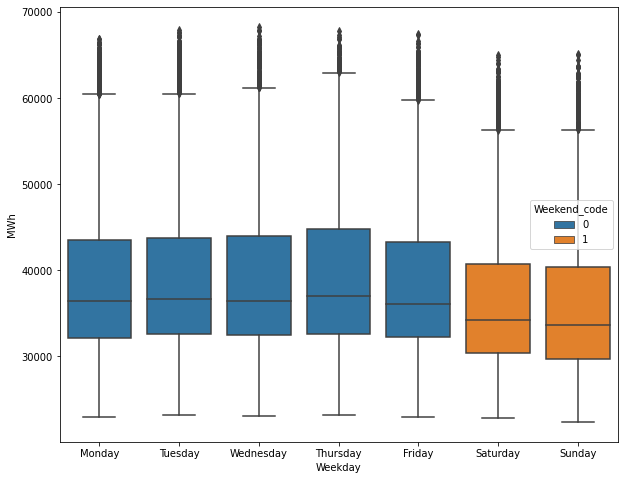

In [ ]:
# plot the boxplot
plt.figure(figsize=(10,8))
plot4 = sns.boxplot(x="Weekday", y="MWh", hue="Weekend_code", data=data, dodge=False)
plot4.set_xticklabels(['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday'])
plt.show()

This boxplot shows the MWh consumption comparison between weekdays and weekends. No matter they are weekdays and weekends, the MWh usages were at the same level. However, we can see that MWh consumption on Saturday and Sunday was slightly lower than on weekdays. Weekdays and weekends are not important factors affecting MWh consumption.

## Statistics of August By Day of MWh and Independent Variables

In [ ]:
august = data[data['Month'] == 8] # subset the data in August
day_info = august.groupby('Day').agg(['mean','min','max']).reset_index() # aggregate the tmpf for mean, min and max and flatten the index
day_info = pd.DataFrame(day_info) # set in the dataframe
day_info = day_info.iloc[:,0:13] # only include the target and independent variables
day_info.head(31) # show the table

Day           MWh                ...       relh               
                mean           min  ...       mean    min     max
0    1  48821.106189  33532.856015  ...  46.067170  15.67   96.93
1    2  48949.298789  30836.975747  ...  36.630729  13.27   87.26
2    3  48966.253323  30495.760594  ...  38.283958  14.07   93.30
3    4  49360.152840  33302.696416  ...  36.595937  16.66   71.22
4    5  49832.027386  34062.130845  ...  38.366392  16.91   73.59
5    6  51247.817409  35633.643801  ...  38.602000  19.71   68.47
6    7  51400.912532  36905.583959  ...  36.586667  17.10   66.43
7    8  51449.791784  36754.706227  ...  35.968454  15.03   65.67
8    9  51288.993006  35397.360422  ...  41.263762  16.91   67.59
9   10  50868.051441  36210.157191  ...  42.246827  14.71   71.22
10  11  49869.513371  33377.457120  ...  43.006762  15.43   78.48
11  12  49410.082623  34382.378607  ...  45.314490  13.04   78.65
12  13  48538.094337  34161.889556  ...  48.895000  25.94   78.72
13  14  48500.135389  33957.449539  ...  49.203627  17.06   90.14
14  15  48283.154877  33897.120574  ...  40.019271  17.95   78.66
15  16  49180.680912  33442.728354  ...  40.927547  21.62   84.80
16  17  47978.355717  31032.534914  ...  50.136852  20.51   93.44
17  18  46016.611469  29544.986891  ...  53.921101  19.58   93.97
18  19  47414.189551  30275.932344  ...  49.372673  14.37   84.16
19  20  48008.900571  30760.301888  ...  45.044948  17.95   83.91
20  21  47748.607070  31969.691485  ...  41.523636  18.17   75.57
21  22  48426.821586  30444.837839  ...  45.199677  21.94   80.86
22  23  48841.360939  31722.566624  ...  41.747789  21.35   71.22
23  24  49791.236145  33165.734502  ...  47.425603  22.22   78.49
24  25  47431.524276  34138.450683  ...  47.061939  20.10   78.49
25  26  47322.110945  33196.725769  ...  47.897187  19.05   81.15
26  27  47298.208951  32157.882267  ...  50.631932  16.42   84.04
27  28  47938.149166  32519.325082  ...  50.301802  11.97  100.00
28  29  48245.805543  34153.913753  ...  43.269902  13.70   78.49
29  30  48445.533767  33629.698732  ...  35.132500  11.38   75.57
30  31  48031.917804  34346.663826  ...  34.582917  14.98   68.47

[31 rows x 13 columns]

Since August has the highest energy consumption with relatively higher temperature among other months, this statistics table provides a closer look at the mean, min, and max of all variables by day in August. All variables have maintained at a steady level through the month. However, 7th has reached the highest temperature and highest energy consumption. This implies the energy consumption may increase under extreme weather.

## The Top Five Hour with the Highest MWh Consumption

In [ ]:
# group the MWh variable by month from 2011 to 2014
hour = data.groupby('Hour') # group by hour
hour_mwh = hour['MWh'].agg(['mean','min','max']).reset_index().sort_values('mean', ascending=False) # aggregate the tmpf for mean, min and max and flatten the index
hour_mwh.head(5) # show the top five time slots

,Hour,mean,min,max
18,18,44425.726786,27602.269711,67808.648008
17,17,44279.861264,26974.892258,68317.669844
19,19,44210.122411,28283.437008,66471.541637
16,16,43760.078731,27063.689273,67923.565924
20,20,43294.708809,28314.241533,64341.232044


This table shows when the highest MWh Consumption was. We can see that the highest MWh consumption ranged between 4PM and 8PM. The energy was consumed during after school and dinner hours. We believe that the energy consumption has increased after the residents got home after school and work. This pattern could help the ERCOT to evaluate the energy demand during these hours in Texas.

# Preparing the data for Modeling

## Data Partition

In [ ]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 38172 entries, 0 to 38171
Data columns (total 20 columns):
 #   Column              Non-Null Count  Dtype         
---  ------              --------------  -----         
 0   Date                38172 non-null  datetime64[ns]
 1   MWh                 38172 non-null  float64       
 2   tmpf                38172 non-null  float64       
 3   dwpf                38172 non-null  float64       
 4   relh                38172 non-null  float64       
 5   Month               38172 non-null  int64         
 6   Hour                38172 non-null  int64         
 7   Day                 38172 non-null  int64         
 8   Weekday             38172 non-null  int64         
 9   Weekday_Name        38172 non-null  object        
 10  Weekend             38172 non-null  object        
 11  Weekend_code        38172 non-null  int64         
 12  tmpf_5hr_roll_avg   38168 non-null  float64       
 13  dwpf_5hr_roll_avg   38168 non-null  float64   

### Input and Target Variables
* Below are our X variables:
  * tmpf
  * dwpf
  * relh
  * Month
  * Hour
  * Day
  * Weekday
  * Weekend_code
  * tmpf_5hr_roll_avg
  * dwpf_5hr_roll_avg
  * tmpf_10hr_roll_avg
  * dwpf_10hr_roll_avg
  * tmpf_24hr_roll_avg
  * dwpf_24hr_roll_avg
  * tmpf_48hr_roll_avg
  * dwpf_48hr_roll_avg

* Target Variable (y) : MWh



In [ ]:
X_train= data.iloc[:,[2,3,4,5,6,7,8,11,12,13,14,15,16,17,18,19]]
#display the shape of X
print(X_train.shape)

y_train = data['MWh']
#display the shape of y- target variable
print(y_train.shape)

(38172, 16)
(38172,)


In [ ]:
target_data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 10492 entries, 2 to 10493
Data columns (total 20 columns):
 #   Column              Non-Null Count  Dtype         
---  ------              --------------  -----         
 0   Date                10492 non-null  datetime64[ns]
 1   MWh                 10492 non-null  float64       
 2   tmpf                10492 non-null  float64       
 3   dwpf                10492 non-null  float64       
 4   relh                10492 non-null  float64       
 5   Month               10492 non-null  int64         
 6   Hour                10492 non-null  int64         
 7   Day                 10492 non-null  int64         
 8   Weekday             10492 non-null  int64         
 9   Weekday_Name        10492 non-null  object        
 10  Weekend             10492 non-null  object        
 11  Weekend_code        10492 non-null  int64         
 12  tmpf_5hr_roll_avg   10488 non-null  float64       
 13  dwpf_5hr_roll_avg   10488 non-null  float64   

In [ ]:
#define X_test on data from 2011 to 2014
X_test = target_data.iloc[:,[2,3,4,5,6,7,8,11,12,13,14,15,16,17,18,19]]
print(X_test.shape)
#define y_test on data from 2015
y_test = target_data['MWh']
print(y_test.shape)


(10492, 16)
(10492,)


##Normalize the data
* We are using minmax Scaler() function to normalize X_train and X_test

In [ ]:
# Normalize the data by using MinMaxScaler()
# for data prep
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
#using minmax Scaler to transform X_train and X_test 
min_max_scaler = MinMaxScaler()
X_train = min_max_scaler.fit_transform(X_train)
X_test = min_max_scaler.transform(X_test)
#print shape of X_train and X_test 
print(X_train.shape, X_test.shape)

(38172, 16) (10492, 16)


## Split Sequence

* Define the split_sequence function
* Save X_train, X_test, y_train and y_test as dataframes
* Merge X_train and y_train into a single dataframe df_train
* Merge X_test and y_test into a single dataframe df_test
* Impute the missing values in df_train and df_test using ffill and bfill
* Apply split_sequence function on df_train to create X_train and y_train, on df_test to create X_test and y_test with a lookback period of 30


In [ ]:
# split a multivariate sequence into samples
def split_sequences(sequences, n_steps):
	X, y = list(), list()
	for i in range(0,len(sequences)): 
		# find the end of this pattern
		end_ix = i + n_steps
		# check if we are beyond the dataset
		if end_ix > len(sequences):
			break
		# gather input and output parts of the pattern
		seq_x, seq_y = sequences[i:end_ix, :-1], sequences[end_ix-1, -1]
		X.append(seq_x)
		y.append(seq_y)
	return np.array(X), np.array(y)

In [ ]:
# save everything as a dataframe
X_train = pd.DataFrame(X_train)
X_test = pd.DataFrame(X_test)
y_train = pd.DataFrame(y_train)
y_test = pd.DataFrame(y_test)

# reset the index on everything
# issue with dates and integers
X_train.reset_index(inplace=True, drop=True)
X_test.reset_index(inplace=True, drop=True)
y_train.reset_index(inplace=True, drop=True)
y_test.reset_index(inplace=True, drop=True)

# put X_train and y_train together 
# put X_test and y_test together 
df_train = pd.concat([X_train, y_train], axis=1)
df_test = pd.concat([X_test, y_test], axis=1)
print(df_train.shape, df_test.shape)

(38172, 17) (10492, 17)


In [ ]:
# check the head
df_train.head()

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,MWh
0,0.246998,0.438795,0.551867,0.0,0.000000,0.0,0.833333,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,28496.388850
1,0.257290,0.450094,0.553588,0.0,0.043478,0.0,0.833333,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,27662.443480
2,0.257290,0.438795,0.527983,0.0,0.086957,0.0,0.833333,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,27250.044715
3,0.246998,0.450094,0.578686,0.0,0.130435,0.0,0.833333,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,26783.226081
4,0.228130,0.450094,0.627973,0.0,0.173913,0.0,0.833333,1.0,0.246767,0.413079,NaN,NaN,NaN,NaN,NaN,NaN,26676.468490


In [ ]:
# check the head
df_test.head()

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,MWh
0,0.142367,0.470810,1.00000,0.0,0.000000,0.0,0.5,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,40707.660350
1,0.150943,0.470810,0.96215,0.0,0.043478,0.0,0.5,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,39624.861027
2,0.150943,0.470810,0.96215,0.0,0.086957,0.0,0.5,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,39013.544802
3,0.150943,0.470810,0.96215,0.0,0.086957,0.0,0.5,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,39013.544802
4,0.150943,0.480226,1.00000,0.0,0.130435,0.0,0.5,0.0,0.146802,0.442323,NaN,NaN,NaN,NaN,NaN,NaN,38566.541927


In [ ]:
#fill missing values with ffill and bfill
df_train = df_train.fillna(method='ffill').fillna(method='bfill')
df_train.head()

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,MWh
0,0.246998,0.438795,0.551867,0.0,0.000000,0.0,0.833333,1.0,0.246767,0.413079,0.243018,0.354846,0.323672,0.2917,0.322766,0.254108,28496.388850
1,0.257290,0.450094,0.553588,0.0,0.043478,0.0,0.833333,1.0,0.246767,0.413079,0.243018,0.354846,0.323672,0.2917,0.322766,0.254108,27662.443480
2,0.257290,0.438795,0.527983,0.0,0.086957,0.0,0.833333,1.0,0.246767,0.413079,0.243018,0.354846,0.323672,0.2917,0.322766,0.254108,27250.044715
3,0.246998,0.450094,0.578686,0.0,0.130435,0.0,0.833333,1.0,0.246767,0.413079,0.243018,0.354846,0.323672,0.2917,0.322766,0.254108,26783.226081
4,0.228130,0.450094,0.627973,0.0,0.173913,0.0,0.833333,1.0,0.246767,0.413079,0.243018,0.354846,0.323672,0.2917,0.322766,0.254108,26676.468490


In [ ]:
#fill missing values with ffill and bfill
df_test = df_test.fillna(method='ffill').fillna(method='bfill')
df_test.head()

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,MWh
0,0.142367,0.470810,1.00000,0.0,0.000000,0.0,0.5,0.0,0.146802,0.442323,0.130941,0.404626,0.143423,0.37362,0.14081,0.352809,40707.660350
1,0.150943,0.470810,0.96215,0.0,0.043478,0.0,0.5,0.0,0.146802,0.442323,0.130941,0.404626,0.143423,0.37362,0.14081,0.352809,39624.861027
2,0.150943,0.470810,0.96215,0.0,0.086957,0.0,0.5,0.0,0.146802,0.442323,0.130941,0.404626,0.143423,0.37362,0.14081,0.352809,39013.544802
3,0.150943,0.470810,0.96215,0.0,0.086957,0.0,0.5,0.0,0.146802,0.442323,0.130941,0.404626,0.143423,0.37362,0.14081,0.352809,39013.544802
4,0.150943,0.480226,1.00000,0.0,0.130435,0.0,0.5,0.0,0.146802,0.442323,0.130941,0.404626,0.143423,0.37362,0.14081,0.352809,38566.541927


In [ ]:
#lookback period of 30
n_steps = 30
#applying split_sequence function on df_train to get X_train and y_train
X_train, y_train = split_sequences(np.array(df_train), n_steps)
#applying split_sequence function on df_test to get X_test and y_test
X_test, y_test = split_sequences(np.array(df_test), n_steps)
# check the shape for X_train and y_train
print(X_train.shape, y_train.shape)
# check the shape for X_test and y_test
print(X_test.shape, y_test.shape) 

(38143, 30, 16) (38143,)
(10463, 30, 16) (10463,)


In [ ]:
# verify no NaN values
print(np.isnan(X_train).sum())
print(np.isnan(y_train).sum())
print(np.isnan(X_test).sum())
print(np.isnan(y_test).sum())

0
0
0
0


In [ ]:
# verify distribution of target variable
print(np.unique(y_train, return_counts=True))
print(np.unique(y_test, return_counts=True))

(array([22366.014254, 22528.264474, 22572.960142, ..., 67923.565924,
       67941.11661 , 68317.669844]), array([1, 1, 1, ..., 1, 1, 1]))
(array([24337.46736797, 24423.69437897, 24550.17718097, ...,
       69438.16267794, 69452.33850894, 69620.40761394]), array([1, 1, 1, ..., 1, 1, 1]))


In [ ]:
print(X_train.shape[1])
print(X_train.shape[2])

30
16


# Modeling

## Model Architecture
* We will be using Sequential API to build the model
  * Filters in Convolution 1D Layer 1: 20
  * Filter size in Maxpooling 1D Layer 1: 2
  * Filters in Convolution 1D Layer 2: 10
  * Filter size in Maxpooling 1D Layer 2: 2
  * Hidden units in Bidirectional LSTM Layer: 100
  * Hidden units in Bidirectional GRU Layer: 75
  * Hidden units in SimpleRNN Layer: 50
  * Hidden units in Dense Layer 1: 40
  * Hidden units in Dense Layer 2: 30
  * Hidden units in Dense Layer 3: 20
  * Hidden units in Dense Layer 4: 10
  * Dropout with 0.1 probability

* Compile the Model using
  * Optimizer: Adam
  * Loss function: mse (Mean Squared Error)
  * Additional Metrics: mae (Mean Absolute Error)

* We will make a new variable called 'history' to evaluate the learning curves. 
  * epochs of 100
  * batch size per epoch: 10
  
* Early Stopping with a patience of 20

* Activation functions used:
  * relu
  * linear (since it is a regression problem)

**Convolutional Layer- Conv1d :**
  * Filter = 20
  * Kernel Size : 2
  * input shape = (n_steps, n_features) = (30,16)

The number of trainable parameters are **660**

We now calculate the output size (So - (M - 1)) = (30 - (2- 1)) = 29

* Conv1D layer has an interface that is similar to Conv2D. Conv1D layer creates a convolution kernel that is convolved with the layer input over a single spatial dimension to produce a tensor of outputs.The number of filters is the new columns that will be created. The kernel size in this case is 2 which dictates the size of the modified lookback.
The first Convolutional Layer Conv1d gives 420 trainable parameters and an output size of (None, 29, 20)



**Maxpooling Layer- max_pooling1d :**

* There are no trainable parameters in a pooling layer. Here in the pooling layer, we are aggressively down sampling with 2 that will never overlap. Also, to get the new dimensions, we divide the axis by filter size, i.e; 2 in this case. 
New Dimension = 29/2 = 14
Coming to the filter, we are inheriting it from the previous convolutional layer (Conv1d) i.e; 20.
The output size of max_pooling1d is (None, 14, 20)


**Convolutional Layer 2- Conv1d :**
  * Filter = 10
  * Kernel Size : 2
  
The number of trainable parameters are **410**

We now calculate the output size (So - (M - 1)) = (14 - (2- 1)) = 13

* Conv1D layer has an interface that is similar to Conv2D. Conv1D layer creates a convolution kernel that is convolved with the layer input over a single spatial dimension to produce a tensor of outputs.The number of filters is the new columns that will be created. The kernel size in this case is 2 which dictates the size of the modified lookback.
The first Convolutional Layer Conv1d gives 410 trainable parameters and an output size of (None, 13, 10)



**Maxpooling Layer- max_pooling1d :**

* There are no trainable parameters in a pooling layer. Here in the pooling layer, we are aggressively down sampling with 2 that will never overlap. Also, to get the new dimensions, we divide the axis by filter size, i.e; 2 in this case. 
New Dimension = 13/2 = 6
Coming to the filter, we are inheriting it from the previous convolutional layer (Conv1d) i.e; 10.
The output size of max_pooling1d is (None, 6, 10)

**Bidirectional LSTM Layer**

* There are two LSTM Layers in this step of the model coming in from two directions.
The value of g is 4 for LSTM since it has 4 feed forward neural network. However since we have a bidirectional LSTM Layer, we multiply g by two while calculating the number of trainable parameters.

  * g = 4
  * h = 100
  * i = 10

* The number of parameters is calcualed as follows\
  = $2 * g * [h * (h + i) + h]$\
  = 2 * 4 * [100 * (100 + 10) + 100]\
  = $88,800$

* We have $88,800$ trainable parameters and the output shape of LSTM Layer is $(None, 6, 200)$

**Bidirectional GRU Layer**

* There are two GRU Layers in this step of the model coming in from two directions.

The value of g is 3 for GRU since it has 3 feed forward neural networks. However since we have a bidirectional GRU Layer, we multiply g by two while calculating the number of trainable parameters.

  * g = 3
  * h = 75
  * i = 200

* We have $124,650$ trainable parameters and the output shape of LSTM Layer is $(None, 6, 150)$

**Simple RNN** (simple_rnn)
* g = 1, since Simple RNN has 1 Feed forward neural network
* h = 50, number of hidden units, these are the red dots
* i = 150, this is inherited from previous layer. The number of hidden layers in previous layer becomes number of input layers in this layer

* The number of parameters is calcualed as follows\
  = $g * [h * (h + i) + h]$\
  = 1 * [50 * (50 + 150) + 50]\
  = $10,050$

* We have $10,050$ trainable parameters and the output shape of Simple RNN Layer is (None, hidden_units) = $(None, 50)$

**Dense Layer 1(dense_1)**
* After all the time steps, the last hidden unit is fed into a dense layer
  * h = 40
  * i = 50, these are the number of inputs going into dense layer
  * o = 0, there is no output

* The number of trainable parameters is calculated by the formula: $(i * h) + (h * o) + (h + o)$ giving us 2040 paramaters. 
The output shape for this layer is $(None, 40)$

**Dense Layer 2(dense_2)**
  * h = 30
  * i = 40, these are the number of inputs going into dense layer
  * o = 0, there is no output

* The number of trainable parameters is calculated by the formula: $(i * h) + (h * o) + (h + o)$ giving us 1230 paramaters. 
The output shape for this layer is $(None, 30)$

**Dense Layer 3(dense_3)**
  * h = 20
  * i = 30, these are the number of inputs going into dense layer
  * o = 0, there is no output

* The number of trainable parameters is calculated by the formula: $(i * h) + (h * o) + (h + o)$ giving us 620 paramaters. 
The output shape for this layer is $(None, 20)$

**Dense Layer 4(dense_4)**
  * h = 10
  * i = 20, these are the number of inputs going into dense layer
  * o = 0, there is no output

* The number of trainable parameters is calculated by the formula: $(i * h) + (h * o) + (h + o)$ giving us 210 paramaters. 
The output shape for this layer is $(None, 10)$

**Dense Layer (dense_6)**
* After all the time steps, the last hidden unit is fed into output layer to make the final prediction.
  * h = 1 
  * i = 10, this is inherited from previous layer and all of these number of inputs go into dense layer
  * o = 0, there is no output

* The number of trainable parameters is calculated by the formula: $(i * h) + (h * o) + (h + o)$ giving us 11 paramaters. The output shape for this layer is $(None, 1)$

**Total Trainabale Parameters**
* The total number of trainable parameters are the sum of two Convolution 1D layers, two Maxpooling 1D layers, Bidirectional LSTM Layer, Bidirectional GRU Layer, Simple RNN and four Dense Layer parameters which is $228,681$


## Build and Fit the Model

In [ ]:
# RNN-specific modules
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import classification_report,accuracy_score
from tensorflow.keras import layers, Sequential
from tensorflow.keras.layers import Conv1D, MaxPooling1D
from tensorflow.keras.layers import Dense, Dropout, SimpleRNN, GRU, LSTM, Bidirectional
from tensorflow.keras.callbacks import EarlyStopping

In [ ]:
#assign n_steps and n_features
n_steps = X_train.shape[1]
n_features = X_train.shape[2]
#build a model using Sequential API
model = Sequential()
#Convolution 1D layer with 20 filters and input shape = (30,16)
model.add(Conv1D(filters=20, kernel_size=2, input_shape=(n_steps,n_features))) 
#Maxpooling 1D layer with filter size = 2
model.add(MaxPooling1D(2))
#Convolution 1D layer with 10 filters
model.add(Conv1D(filters=10, kernel_size=2,))
#Maxpooling 1D layer with filter size = 2
model.add(MaxPooling1D(2))
#Bidirectional LSTM layer with 100 hidden units
model.add(Bidirectional(LSTM(100, activation='relu', recurrent_dropout=0.2, return_sequences=True)))
#Bidirectional GRU layer with 75 hidden units
model.add(Bidirectional(GRU(75, activation='relu', recurrent_dropout=0.2, return_sequences=True)))
#SimpleRNN layer with 50 hidden units
model.add(SimpleRNN(50, activation='relu', recurrent_dropout=0.2))
#Dense Layer 1 with 40 hidden units
model.add(Dense(40, activation='relu'))
#Dense Layer 2 with 30 hidden units
model.add(Dense(30, activation='relu'))
#Dense Layer 3 with 20 hidden units
model.add(Dense(20, activation='relu'))
#Dense Layer 4 with 10 hidden units
model.add(Dense(10, activation='relu'))
#Dropout function with 0.1 probability
model.add(Dropout(0.1))
#Output layer with activation function 'linear' as it is a regression problem
model.add(Dense(1, activation='linear'))
#compile the model using 'adam' optimizer
model.compile(optimizer='adam', loss='mse',metrics=['mae'])
#Print the model summary
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_2 (Conv1D)            (None, 29, 20)            660       
_________________________________________________________________
max_pooling1d_2 (MaxPooling1 (None, 14, 20)            0         
_________________________________________________________________
conv1d_3 (Conv1D)            (None, 13, 10)            410       
_________________________________________________________________
max_pooling1d_3 (MaxPooling1 (None, 6, 10)             0         
_________________________________________________________________
bidirectional_2 (Bidirection (None, 6, 200)            88800     
_________________________________________________________________
bidirectional_3 (Bidirection (None, 6, 150)            124650    
_________________________________________________________________
simple_rnn_1 (SimpleRNN)     (None, 50)               

In [ ]:
# early stopping with a patience of 20
es = EarlyStopping(monitor='val_loss', mode='min', 
                   patience=20, 
                   verbose=1,
                   restore_best_weights=True)

# fit the model with 100 epochs
history = model.fit(X_train, y_train,
                    callbacks=[es],
                    epochs=100,
                    batch_size=10,
                    validation_data=(X_test, y_test),
                    verbose=1,
                    shuffle=True)

Epoch 1/100
3815/3815 [==============================] - 183s 46ms/step - loss: 223671109.8218 - mae: 10959.8386 - val_loss: 68890904.0000 - val_mae: 6827.4141
Epoch 2/100
3815/3815 [==============================] - 171s 45ms/step - loss: 80687079.7799 - mae: 6909.5669 - val_loss: 20660934.0000 - val_mae: 3385.1199
Epoch 3/100
3815/3815 [==============================] - 172s 45ms/step - loss: 70516377.7778 - mae: 6459.4342 - val_loss: 77438288.0000 - val_mae: 7608.0874
Epoch 4/100
3815/3815 [==============================] - 172s 45ms/step - loss: 66846974.4384 - mae: 6256.8212 - val_loss: 43163272.0000 - val_mae: 5422.8013
Epoch 5/100
3815/3815 [==============================] - 179s 47ms/step - loss: 62895866.9602 - mae: 6099.4316 - val_loss: 50710600.0000 - val_mae: 5749.3306
Epoch 6/100
3815/3815 [==============================] - 186s 49ms/step - loss: 59957963.2998 - mae: 5898.9760 - val_loss: 81098984.0000 - val_mae: 7932.3867
Epoch 7/100
3815/3815 [===========================

## Evaluate the model

In [ ]:
# make a prediction
pred = model.predict(X_test)
pred = np.round(pred,0)

In [ ]:
#print the lowest MAE for the model
from sklearn.metrics import mean_absolute_error
print('MAE: ', mean_absolute_error(y_test, pred))

MAE:  2519.8906424341053


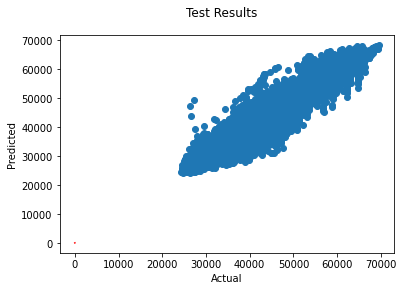

In [ ]:
#plotting the test results, Actuals vs Predicted
actual = y_test # the actual
plt.scatter(x=actual, y=pred)
x = np.linspace(0,25) 
plt.plot(x, x, color='red')
plt.suptitle('Test Results')
plt.xlabel('Actual')
plt.ylabel('Predicted')
plt.show()

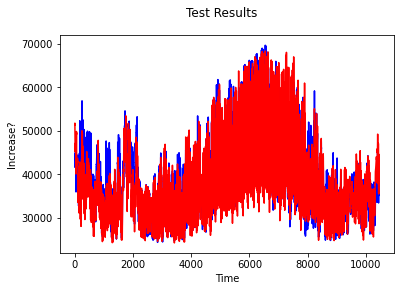

In [ ]:
# show timeseries plot on the train and validation data
plt.plot(np.arange(X_test.shape[0]), y_test, color='blue') # actual data
plt.plot(np.arange(X_test.shape[0]), pred, color='red') # predicted data
plt.suptitle('Test Results')
plt.xlabel('Time')
plt.ylabel('Increase?')
plt.show()

In [ ]:
# now you could plot the epochs and train for exactly that many...
#creating a dictionary of keys with loss, mae, validation loss and validation mae
history.history.keys()

dict_keys(['loss', 'mae', 'val_loss', 'val_mae'])

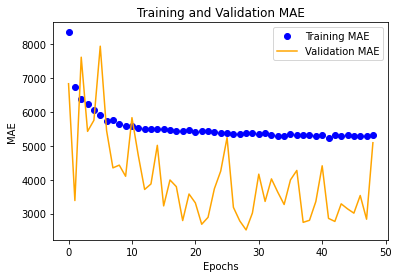

In [ ]:
# plotting the graph to see the training and validation loss by epoch
import matplotlib.pyplot as plt

mae = history.history['mae']
val_mae = history.history['val_mae']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(mae)) #number of epochs
#plotting training and validation MAE
# "bo" is for "blue dot"
plt.plot(epochs, mae, 'bo', label='Training MAE')
# orange is for "solid orange line"
plt.plot(epochs, val_mae, 'orange', label='Validation MAE')
plt.title('Training and Validation MAE')
plt.xlabel("Epochs")
plt.ylabel("MAE")
plt.legend()
plt.show()


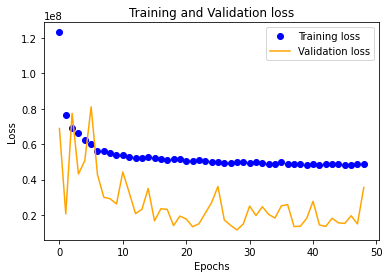

In [ ]:
plt.figure()
#plotting training and validation loss
plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'orange', label='Validation loss')
plt.title('Training and Validation loss')
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()

plt.show()

# Analysis

* When looking at the EDA for this dataset, we noticed that `tmpf` is a key driver and has a positive correlation with our target variable, `MWh`. When temperature increases, energy consumption relatively increases.

* The boxplots regarding holidays, weekdays, and weekends reveal that the energy consumption remains at a similar level as normal days during holidays and weekends. However, the Holidays boxplot shows that the energy consumption on the holidays during Summer is relatively higher. It further supports temperature is a key driver for energy consumption.

* The top five-hour table tells us that the highest energy consumption ranges from 4 PM to 8 PM. If the weather becomes extreme, we believe that energy consumption will be very critical during this period.

* The model that gave us the lowest MAE is a monster which has stacked layers of two Convolution 1D layers, two Maxpooling 1D layers, Bidirectional LSTM, Bidirectional GRU, SimpleRNN, four dense layers and a dropout function with 0.1 probability. We tried multiple model architectures from just a simple LSTM layer to multiple Bidirectional Layers stacked on top of each other. However, the model that had Conv1D and Maxpooling 1D layers performed the best. 

* The final model has 30 lookbacks in the Data Partition step giving us the best performing model. Although we tried with lookbacks of 5, 20, 30 and 50, 5 and 20 the low performing models while lookbacks 30 and 50 were on par with each other. However, model with 30 lookbacks slightly performed better than model with 50 lookbacks.

* The model that we chose gave us the lowest MAE of 2519.89 with 100 epochs, 10 batch size and early stopping with a patience of 20. The best val_mae was obtained at epoch 29 with the val_loss of 11583227.00,
where as the loss and mae on training data for epoch 29 are 49902017.7521 and 5377.1522 respectively.

* The final statistic for  epoch 29 which gives the lowest mae are as follows:
  * loss: 49902017.7521
  * mae: 5377.1522
  * val_loss: 11583227.0000
  * val_mae: 2519.89

* In time series plots for test results, we see that the model is converging very well on test data, it starts with few misses initially but performs well later on.


